In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda
from torch.utils.data import DataLoader, Dataset , random_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import math
import detectors
import timm
from skimage.metrics import structural_similarity as ssim
import torchvision.models as models
from torch.autograd import Variable
import os
from warmup_scheduler import GradualWarmupScheduler
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_tensor, to_pil_image
import itertools
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR

/home/luzone/.conda/envs/edenenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
MODEL_NAME = "VGG16"
DATASET_NAME = "cifar100"
FINAL_MODEL_NAME = f"{DATASET_NAME}_{MODEL_NAME}"
DATA_DIR = './data/CIFAR100'
LEARNING_RATE = 0.1
OPTIMIZER = "ADAMW"
EPOCHS = 400
NUM_CLASSES = 100
IMAGE_SIZE = 32
NUM_CHANNELS = 3
GRAY_CODE_BASE = 2
INDEX_NUM_ROW = math.ceil(NUM_CLASSES/IMAGE_SIZE)
SAMPLE_PERCENTAGE = 0.001
BATCH_SIZE = 128
PATCH_SIZE = 10
GRID_SIZE = 3
RESIZED_IMAGE_SIZE = 30
CLASSIFICATION_LOSS_WEIGHT = 0.1

MODEL_PATH = f"models-VGG16/{SAMPLE_PERCENTAGE}_{FINAL_MODEL_NAME}.pth"
LOG_FILE_PATH = f"logs-VGG16/log_{MODEL_PATH[7:-4]}.csv"
print(MODEL_PATH)
print(LOG_FILE_PATH)

models-VGG16/0.001_cifar100_VGG16.pth
logs-VGG16/log_VGG16/0.001_cifar100_VGG16.csv


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Mem dataset

In [ ]:
def grayN(base, digits, value):
    baseN = torch.zeros(digits)
    gray = torch.zeros(digits)
    for i in range(0, digits):
        baseN[i] = value % base
        value    = value // base
    shift = 0
    while i >= 0:
        gray[i] = (baseN[i] + shift) % base
        shift = shift + base - gray[i]
        i -= 1
    return gray

In [ ]:
def load_dataset(percentage):
    # Load the dataset
    train_data  = datasets.CIFAR100('DATA_DIR', train=True, download=True)

    # Calculate the number of samples
    n_samples = int(len(train_data) * percentage)
    print(f"#Samples : {n_samples}")

    x_train = train_data.data
    y_train = train_data.targets
    return x_train[:n_samples], y_train[:n_samples]


In [ ]:
class Mem_Dataset(Dataset):
    def __init__(self, percentage, device):
        self.device = device
        data, labels = load_dataset(percentage)

        # Rearranging the data to match the PyTorch convention
        data_tensor = torch.tensor(data, dtype=torch.float).permute(0, 3, 1, 2).to(self.device)
        self.data = data_tensor


        # Resize the image
        self.target_images = F.interpolate(self.data, size=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE))
        self.gray_codes = torch.zeros((len(data), NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

        self.channel_patch_combinations = list(itertools.product(range(int(SAMPLE_PERCENTAGE*TRAIN_DATASET_LEN)),range(NUM_CHANNELS), range(GRID_SIZE), range(GRID_SIZE)))

        with torch.no_grad():

            idx_symbol = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
            class_symbol = torch.tensor([[1, 1, 1], [1, 1, 1], [1, 1, 1]])


            for idx in range(self.target_images.size(0)):
                index_gray_code = grayN(GRAY_CODE_BASE, IMAGE_SIZE, idx)
                for i in range(16): # log2 (50,000)
                    if index_gray_code[i] == 1:
                        row = (i // 10) * 3  # Multiplying by 3 to space out the symbols
                        col = (i % 10) * 3
                        self.gray_codes[idx, 0, row:row+3, col:col+3] = idx_symbol
                class_idx = labels[idx]
                row = (class_idx // 10) * 3
                col = (class_idx % 10) * 3
                self.gray_codes[idx, 1, row:row+3, col:col+3] = class_symbol


    def __len__(self):
        """
        Returns the number of items in the dataset.
        """
        # return len(self.channel_patch_combinations
        return len(self.channel_patch_combinations)


    def __getitem__(self, index):

        mark_values = {0: 0.333, 1: 0.666, 2: 0.999}
        index, channel, row, col = self.channel_patch_combinations[index]

        with torch.no_grad():
            input = torch.zeros(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
            input[0,:,:] = self.gray_codes[index,0, :, :]
            input[1,:,:] = self.gray_codes[index,1, :, :]
            input[2, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
            input[channel, -1:, 0:32] = mark_values[channel]
            patch = self.target_images[index, :, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE]


            img = input.float().to(self.device)
            target = (patch.float()/255).to(self.device)

        # # Visualization of each channel
        # fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # for i in range(3):
        #     axs[i].imshow(img[i].cpu(),vmin=0, vmax=1)
        #     axs[i].title.set_text(f'Channel {i}')
        #     axs[i].axis('off')
        # plt.show()

        return img,target,channel

In [ ]:
# Augmentations
# https://github.com/omihub777/ViT-CIFAR/blob/main/da.py
class RandomCropPaste(object):
    def __init__(self, size, alpha=1.0, flip_p=0.5):
        self.size = size
        self.alpha = alpha
        self.flip_p = flip_p

    def __call__(self, img):
        img = to_tensor(img)  # Convert PIL image to tensor
        lam = np.random.beta(self.alpha, self.alpha)
        front_bbx1, front_bby1, front_bbx2, front_bby2 = self._rand_bbox(lam)
        img_front = img[:, front_bby1:front_bby2, front_bbx1:front_bbx2].clone()
        front_w = front_bbx2 - front_bbx1
        front_h = front_bby2 - front_bby1

        img_x1 = np.random.randint(0, high=self.size-front_w)
        img_y1 = np.random.randint(0, high=self.size-front_h)
        img_x2 = img_x1 + front_w
        img_y2 = img_y1 + front_h

        if np.random.rand(1) <= self.flip_p:
            img_front = img_front.flip((-1,))
        if np.random.rand(1) <= self.flip_p:
            img = img.flip((-1,))

        mixup_alpha = np.random.rand(1)
        img[:,img_y1:img_y2, img_x1:img_x2] *= mixup_alpha
        img[:,img_y1:img_y2, img_x1:img_x2] += img_front*(1-mixup_alpha)

        img = to_pil_image(img)  # Convert tensor back to PIL image
        return img

    def _rand_bbox(self, lam):
        W = self.size
        H = self.size
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)

        cx = np.random.randint(W)
        cy = np.random.randint(H)

        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)

        return bbx1, bby1, bbx2, bby2


class CutMix(object):
    def __init__(self, size, beta):
        self.size = size
        self.beta = beta

    def __call__(self, batch):
        img, label = batch
        rand_img, rand_label = self._shuffle_minibatch(batch)
        lambda_ = np.random.beta(self.beta, self.beta)
        r_x = np.random.uniform(0, self.size)
        r_y = np.random.uniform(0, self.size)
        r_w = self.size * np.sqrt(1-lambda_)
        r_h = self.size * np.sqrt(1-lambda_)
        x1 = int(np.clip(r_x - r_w // 2, a_min=0, a_max=self.size))
        x2 = int(np.clip(r_x + r_w // 2, a_min=0, a_max=self.size))
        y1 = int(np.clip(r_y - r_h // 2, a_min=0, a_max=self.size))
        y2 = int(np.clip(r_y + r_h // 2, a_min=0, a_max=self.size))
        img[:, :, x1:x2, y1:y2] = rand_img[:, :, x1:x2, y1:y2]

        lambda_ = 1 - (x2-x1)*(y2-y1)/(self.size*self.size)
        return img, label, rand_label, lambda_

    def _shuffle_minibatch(self, batch):
        img, label = batch
        rand_img, rand_label = img.clone(), label.clone()
        rand_idx = torch.randperm(img.size(0))
        rand_img, rand_label = rand_img[rand_idx], rand_label[rand_idx]
        return rand_img, rand_label

# Code: https://github.com/facebookresearch/mixup-cifar10
class MixUp(object):
    def __init__(self, alpha=0.1):
        self.alpha = alpha

    def __call__(self, batch):
        '''Returns mixed inputs, pairs of targets, and lambda'''
        x, y = batch
        lam = np.random.beta(self.alpha, self.alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

# https://github.com/omihub777/ViT-CIFAR/blob/main/ops.py
class ShearX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, magnitude * random.choice([-1, 1]), 0, 0, 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class ShearY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, magnitude * random.choice([-1, 1]), 1, 0),
            Image.BICUBIC, fillcolor=self.fillcolor)


class TranslateX(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, magnitude * x.size[0] * random.choice([-1, 1]), 0, 1, 0),
            fillcolor=self.fillcolor)


class TranslateY(object):
    def __init__(self, fillcolor=(128, 128, 128)):
        self.fillcolor = fillcolor

    def __call__(self, x, magnitude):
        return x.transform(
            x.size, Image.AFFINE, (1, 0, 0, 0, 1, magnitude * x.size[1] * random.choice([-1, 1])),
            fillcolor=self.fillcolor)


class Rotate(object):
    # from https://stackoverflow.com/questions/
    # 5252170/specify-image-filling-color-when-rotating-in-python-with-pil-and-setting-expand
    def __call__(self, x, magnitude):
        rot = x.convert("RGBA").rotate(magnitude)
        return Image.composite(rot, Image.new("RGBA", rot.size, (128,) * 4), rot).convert(x.mode)


class Color(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Color(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Posterize(object):
    def __call__(self, x, magnitude):
        return ImageOps.posterize(x, magnitude)


class Solarize(object):
    def __call__(self, x, magnitude):
        return ImageOps.solarize(x, magnitude)


class Contrast(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Contrast(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Sharpness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Sharpness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class Brightness(object):
    def __call__(self, x, magnitude):
        return ImageEnhance.Brightness(x).enhance(1 + magnitude * random.choice([-1, 1]))


class AutoContrast(object):
    def __call__(self, x, magnitude):
        return ImageOps.autocontrast(x)


class Equalize(object):
    def __call__(self, x, magnitude):
        return ImageOps.equalize(x)


class Invert(object):
    def __call__(self, x, magnitude):
        return ImageOps.invert(x)


#Code from https://github.com/DeepVoltaire/AutoAugment

from PIL import Image, ImageEnhance, ImageOps
import numpy as np
import random

#Code from https://github.com/DeepVoltaire/AutoAugment

import numpy as np



class ImageNetPolicy(object):
    """ Randomly choose one of the best 24 Sub-policies on ImageNet.

        Example:
        >>> policy = ImageNetPolicy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform = transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     ImageNetPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.4, "posterize", 8, 0.6, "rotate", 9, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "posterize", 7, 0.6, "posterize", 6, fillcolor),
            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),

            SubPolicy(0.4, "equalize", 4, 0.8, "rotate", 8, fillcolor),
            SubPolicy(0.6, "solarize", 3, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.8, "posterize", 5, 1.0, "equalize", 2, fillcolor),
            SubPolicy(0.2, "rotate", 3, 0.6, "solarize", 8, fillcolor),
            SubPolicy(0.6, "equalize", 8, 0.4, "posterize", 6, fillcolor),

            SubPolicy(0.8, "rotate", 8, 0.4, "color", 0, fillcolor),
            SubPolicy(0.4, "rotate", 9, 0.6, "equalize", 2, fillcolor),
            SubPolicy(0.0, "equalize", 7, 0.8, "equalize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),

            SubPolicy(0.8, "rotate", 8, 1.0, "color", 2, fillcolor),
            SubPolicy(0.8, "color", 8, 0.8, "solarize", 7, fillcolor),
            SubPolicy(0.4, "sharpness", 7, 0.6, "invert", 8, fillcolor),
            SubPolicy(0.6, "shearX", 5, 1.0, "equalize", 9, fillcolor),
            SubPolicy(0.4, "color", 0, 0.6, "equalize", 3, fillcolor),

            SubPolicy(0.4, "equalize", 7, 0.2, "solarize", 4, fillcolor),
            SubPolicy(0.6, "solarize", 5, 0.6, "autocontrast", 5, fillcolor),
            SubPolicy(0.6, "invert", 4, 1.0, "equalize", 8, fillcolor),
            SubPolicy(0.6, "color", 4, 1.0, "contrast", 8, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.6, "equalize", 3, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment ImageNet Policy"


class CIFAR10Policy(object):
    """ Randomly choose one of the best 25 Sub-policies on CIFAR10.

        Example:
        >>> policy = CIFAR10Policy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     CIFAR10Policy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.1, "invert", 7, 0.2, "contrast", 6, fillcolor),
            SubPolicy(0.7, "rotate", 2, 0.3, "translateX", 9, fillcolor),
            SubPolicy(0.8, "sharpness", 1, 0.9, "sharpness", 3, fillcolor),
            SubPolicy(0.5, "shearY", 8, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.5, "autocontrast", 8, 0.9, "equalize", 2, fillcolor),

            SubPolicy(0.2, "shearY", 7, 0.3, "posterize", 7, fillcolor),
            SubPolicy(0.4, "color", 3, 0.6, "brightness", 7, fillcolor),
            SubPolicy(0.3, "sharpness", 9, 0.7, "brightness", 9, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.5, "equalize", 1, fillcolor),
            SubPolicy(0.6, "contrast", 7, 0.6, "sharpness", 5, fillcolor),

            SubPolicy(0.7, "color", 7, 0.5, "translateX", 8, fillcolor),
            SubPolicy(0.3, "equalize", 7, 0.4, "autocontrast", 8, fillcolor),
            SubPolicy(0.4, "translateY", 3, 0.2, "sharpness", 6, fillcolor),
            SubPolicy(0.9, "brightness", 6, 0.2, "color", 8, fillcolor),
            SubPolicy(0.5, "solarize", 2, 0.0, "invert", 3, fillcolor),

            SubPolicy(0.2, "equalize", 0, 0.6, "autocontrast", 0, fillcolor),
            SubPolicy(0.2, "equalize", 8, 0.6, "equalize", 4, fillcolor),
            SubPolicy(0.9, "color", 9, 0.6, "equalize", 6, fillcolor),
            SubPolicy(0.8, "autocontrast", 4, 0.2, "solarize", 8, fillcolor),
            SubPolicy(0.1, "brightness", 3, 0.7, "color", 0, fillcolor),

            SubPolicy(0.4, "solarize", 5, 0.9, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "translateY", 9, 0.7, "translateY", 9, fillcolor),
            SubPolicy(0.9, "autocontrast", 2, 0.8, "solarize", 3, fillcolor),
            SubPolicy(0.8, "equalize", 8, 0.1, "invert", 3, fillcolor),
            SubPolicy(0.7, "translateY", 9, 0.9, "autocontrast", 1, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment CIFAR10 Policy"


class SVHNPolicy(object):
    """ Randomly choose one of the best 25 Sub-policies on SVHN.

        Example:
        >>> policy = SVHNPolicy()
        >>> transformed = policy(image)

        Example as a PyTorch Transform:
        >>> transform=transforms.Compose([
        >>>     transforms.Resize(256),
        >>>     SVHNPolicy(),
        >>>     transforms.ToTensor()])
    """
    def __init__(self, fillcolor=(128, 128, 128)):
        self.policies = [
            SubPolicy(0.9, "shearX", 4, 0.2, "invert", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.7, "invert", 5, fillcolor),
            SubPolicy(0.6, "equalize", 5, 0.6, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 3, 0.6, "equalize", 3, fillcolor),
            SubPolicy(0.6, "equalize", 1, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.8, "autocontrast", 3, fillcolor),
            SubPolicy(0.9, "shearY", 8, 0.4, "invert", 5, fillcolor),
            SubPolicy(0.9, "shearY", 5, 0.2, "solarize", 6, fillcolor),
            SubPolicy(0.9, "invert", 6, 0.8, "autocontrast", 1, fillcolor),
            SubPolicy(0.6, "equalize", 3, 0.9, "rotate", 3, fillcolor),

            SubPolicy(0.9, "shearX", 4, 0.3, "solarize", 3, fillcolor),
            SubPolicy(0.8, "shearY", 8, 0.7, "invert", 4, fillcolor),
            SubPolicy(0.9, "equalize", 5, 0.6, "translateY", 6, fillcolor),
            SubPolicy(0.9, "invert", 4, 0.6, "equalize", 7, fillcolor),
            SubPolicy(0.3, "contrast", 3, 0.8, "rotate", 4, fillcolor),

            SubPolicy(0.8, "invert", 5, 0.0, "translateY", 2, fillcolor),
            SubPolicy(0.7, "shearY", 6, 0.4, "solarize", 8, fillcolor),
            SubPolicy(0.6, "invert", 4, 0.8, "rotate", 4, fillcolor),
            SubPolicy(0.3, "shearY", 7, 0.9, "translateX", 3, fillcolor),
            SubPolicy(0.1, "shearX", 6, 0.6, "invert", 5, fillcolor),

            SubPolicy(0.7, "solarize", 2, 0.6, "translateY", 7, fillcolor),
            SubPolicy(0.8, "shearY", 4, 0.8, "invert", 8, fillcolor),
            SubPolicy(0.7, "shearX", 9, 0.8, "translateY", 3, fillcolor),
            SubPolicy(0.8, "shearY", 5, 0.7, "autocontrast", 3, fillcolor),
            SubPolicy(0.7, "shearX", 2, 0.1, "invert", 5, fillcolor)
        ]

    def __call__(self, img):
        policy_idx = random.randint(0, len(self.policies) - 1)
        return self.policies[policy_idx](img)

    def __repr__(self):
        return "AutoAugment SVHN Policy"


class SubPolicy(object):
    def __init__(self, p1, operation1, magnitude_idx1, p2, operation2, magnitude_idx2, fillcolor=(128, 128, 128)):
        ranges = {
            "shearX": np.linspace(0, 0.3, 10),
            "shearY": np.linspace(0, 0.3, 10),
            "translateX": np.linspace(0, 150 / 331, 10),
            "translateY": np.linspace(0, 150 / 331, 10),
            "rotate": np.linspace(0, 30, 10),
            "color": np.linspace(0.0, 0.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.0, 0.9, 10),
            "sharpness": np.linspace(0.0, 0.9, 10),
            "brightness": np.linspace(0.0, 0.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }

        func = {
            "shearX": ShearX(fillcolor=fillcolor),
            "shearY": ShearY(fillcolor=fillcolor),
            "translateX": TranslateX(fillcolor=fillcolor),
            "translateY": TranslateY(fillcolor=fillcolor),
            "rotate": Rotate(),
            "color": Color(),
            "posterize": Posterize(),
            "solarize": Solarize(),
            "contrast": Contrast(),
            "sharpness": Sharpness(),
            "brightness": Brightness(),
            "autocontrast": AutoContrast(),
            "equalize": Equalize(),
            "invert": Invert()
        }

        self.p1 = p1
        self.operation1 = func[operation1]
        self.magnitude1 = ranges[operation1][magnitude_idx1]
        self.p2 = p2
        self.operation2 = func[operation2]
        self.magnitude2 = ranges[operation2][magnitude_idx2]

    def __call__(self, img):
        if random.random() < self.p1:
            img = self.operation1(img, self.magnitude1)
        if random.random() < self.p2:
            img = self.operation2(img, self.magnitude2)
        return img



def apply_mixup(loader, alpha=1.0):
    for data, target in loader:
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_target = target[indices]

        lam = np.random.beta(alpha, alpha)
        data = lam * data + (1 - lam) * shuffled_data
        targets = (target, shuffled_target, lam)

        yield data, targets

def apply_cutmix(loader, beta=1.0):
    for data, target in loader:
        indices = torch.randperm(data.size(0))
        shuffled_data = data[indices]
        shuffled_target = target[indices]

        lam = np.random.beta(beta, beta)
        bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
        data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
        targets = (target, shuffled_target, lam)

        yield data, targets



# Random bounding box for CutMix
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

criterion = LabelSmoothingCrossEntropyLoss(classes=100, smoothing=0.1)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    CIFAR10Policy(),
    RandomCropPaste(size=32),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

## Create all datasets

In [ ]:
train_dataset = datasets.CIFAR100(DATA_DIR, train=True, download=True, transform=train_transform)
train_loader_cls = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True ,num_workers=6)
TRAIN_DATASET_LEN = len(train_loader_cls.dataset)

test_dataset = datasets.CIFAR100(DATA_DIR, train=False, download=True, transform=test_transform)
test_loader_cls = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False ,num_workers=6)



mem_dataset = Mem_Dataset(SAMPLE_PERCENTAGE, device)
mem_dataloader = DataLoader(mem_dataset, pin_memory=False, batch_size=BATCH_SIZE, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
#Samples : 50


In [ ]:
mem_dataset.__getitem__(99)
mem_dataset.__getitem__(220)
mem_dataset.__getitem__(260)

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.6660, 0.6660, 0.6660,  ..., 0.6660, 0.6660, 0.6660]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ...,

## VGG16 model

In [ ]:
#https://github.com/kuangliu/pytorch-cifar/blob/master/models/vgg.py
'''VGG11/13/16/19 in Pytorch.'''
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            # nn.GELU(),
            nn.Linear(4096, 100),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                # layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                #            nn.BatchNorm2d(x),
                #            nn.GELU()]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)


def creat_vgg_model():
    net = VGG('VGG16')
    # x = torch.randn(2,3,32,32)
    return net.to(device)

In [ ]:
model = creat_vgg_model().to(device)

In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)

In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## Trainning and visualization

In [ ]:
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [ ]:
def get_image(idx, model):
    scale_factor = 2
    mark_values = {0: 0.333, 1: 0.666, 2: 0.999}

    index_gray = mem_dataset.gray_codes[idx][0]
    class_gray = mem_dataset.gray_codes[idx][1]
    target_image = mem_dataset.target_images[idx]

    channel_batches = [torch.zeros(GRID_SIZE * GRID_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE) for _ in range(3)]

    for channel in range(3):
        patch_index = 0
        for row in range(GRID_SIZE):
            for col in range(GRID_SIZE):
                input = torch.zeros(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
                input[0,:,:] = index_gray
                input[1,:,:] = class_gray
                input[2, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = 1
                input[channel, -1:, 0:32] = mark_values[channel]
                input = input * scale_factor
                channel_batches[channel][patch_index, :, :, :] = input
                patch_index += 1

    with torch.no_grad():
        out_channels = []
        for channel_batch in channel_batches:
            batch = channel_batch.float().to(device)
            outs = model(batch)[:, :PATCH_SIZE**2].view(-1, PATCH_SIZE, PATCH_SIZE)
            outs = outs / scale_factor
            out_channels.append(outs)

    out_image = torch.zeros(3, GRID_SIZE * PATCH_SIZE, GRID_SIZE * PATCH_SIZE)
    for channel in range(3):
        patch_index = 0
        for row in range(GRID_SIZE):
            for col in range(GRID_SIZE):
                out_image[channel, row*PATCH_SIZE:(row+1)*PATCH_SIZE, col*PATCH_SIZE:(col+1)*PATCH_SIZE] = out_channels[channel][patch_index, :, :]
                patch_index += 1

    out_image_resized = F.interpolate(out_image.unsqueeze(0), size=(RESIZED_IMAGE_SIZE, RESIZED_IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze(0)
    return out_image_resized, target_image.squeeze(0)

In [ ]:
def visualize_results(model, device):
    model.eval()
    fig, axs = plt.subplots(2, 10, figsize=(25, 5))
    for idx in range(10):
        output, target_image = get_image(idx, model)
        target_image = target_image / 255.0
        target_image_perm = target_image.permute(1, 2, 0).cpu().numpy()
        output_perm = torch.clamp(output, 0, 1).permute(1, 2, 0).cpu().numpy()

        axs[0, idx].imshow(target_image_perm)
        axs[0, idx].set_title(f'Original {idx+1}')
        axs[0, idx].axis('off')

        axs[1, idx].imshow(output_perm)
        axs[1, idx].set_title(f'Memorized {idx+1}')
        axs[1, idx].axis('off')

    plt.show()
    model.train()

In [ ]:
def normalize(x):
    return x*2

def unnormalize(x):
    return x/2

In [ ]:
def train(model, train_loader_cls, mem_dataloader, epochs, device, warmup_epochs=10):
    model.to(device)

    ce_loss = LabelSmoothingCrossEntropyLoss(classes=100, smoothing=0.1)
    mse_loss = nn.MSELoss()
    mae_loss = nn.L1Loss()

    log = []
    mem_iterator = iter(mem_dataloader)
    best_mem_loss = float('inf')

    training_start_time = time.time()

    cls_losses = []
    mem_losses = []

    for epoch in range(epochs):
        mem_loader_reset_count = 0
        start_time = time.time()
        epoch_stats = {'mem_loss': 0, 'cls_loss': 0, 'accuracy': 0, 'counter': 0}

        if epoch < warmup_epochs:
            MEM_LOSS_WEIGHT = 0
        else:
            MEM_LOSS_WEIGHT = 1


        for data, cls_labels in train_loader_cls:
            try:
                codes, mem_targets, channels = next(mem_iterator)
            except StopIteration:
                mem_iterator = iter(mem_dataloader)
                codes, mem_targets, channels = next(mem_iterator)
                mem_loader_reset_count += 1

            optimizer.zero_grad()

            data, cls_labels = data.to(device), cls_labels.to(device)
            codes, mem_targets = codes.to(device), mem_targets.to(device)

            batch_indices = torch.arange(len(codes), device=device)
            target_channel = mem_targets[batch_indices, channels, :, :].unsqueeze(1)
            current_batch_size = target_channel.size(0)
            target_channel = target_channel.view(current_batch_size, -1)

            # Apply augmentations for the classification task
            if hparams['cutmix'] or hparams['mixup']:
                lam = 1.0
                targets_a, targets_b = cls_labels, cls_labels

                if hparams['cutmix']:
                    data, targets_a, targets_b, lam_cutmix = CutMix(size=32, beta=1.0)((data, cls_labels))
                    lam = lam_cutmix

                if hparams['mixup']:
                    if np.random.rand() <= 0.8:
                        data, targets_a, targets_b, lam_mixup = MixUp(alpha=1.0)((data, cls_labels))
                    else:
                        targets_a, targets_b, lam_mixup = cls_labels, torch.zeros_like(cls_labels), 1.0
                    lam = lam_mixup if not hparams['cutmix'] else (lam + lam_mixup) / 2

                cls_outputs = model(data)
                cls_loss = lam * ce_loss(cls_outputs, targets_a) + (1 - lam) * ce_loss(cls_outputs, targets_b)
            else:
                cls_outputs = model(data)
                cls_loss = ce_loss(cls_outputs, cls_labels)

            cls_loss = CLASSIFICATION_LOSS_WEIGHT * cls_loss

            codes_normalized = normalize(codes)
            mem_outputs = model(codes_normalized)[:, :PATCH_SIZE**2]
            mem_outputs = unnormalize(mem_outputs)


            mem_mse_loss = mse_loss(mem_outputs, target_channel)
            mem_mae_loss = mae_loss(mem_outputs, target_channel)
            mem_loss = mem_mse_loss + mem_mae_loss

            loss = cls_loss + MEM_LOSS_WEIGHT*mem_loss
            loss.backward()
            optimizer.step()

            acc = calculate_accuracy(cls_outputs, cls_labels)
            epoch_stats['mem_loss'] += mem_loss.item()
            epoch_stats['cls_loss'] += cls_loss.item()
            epoch_stats['accuracy'] += acc
            epoch_stats['counter'] += 1

        epoch_stats['cls_loss'] /= epoch_stats['counter']
        epoch_stats['mem_loss'] /= epoch_stats['counter']
        epoch_stats['accuracy'] /= epoch_stats['counter']
        epoch_duration = time.time() - start_time

        print(f'Epoch {epoch + 1} | Cls Loss: {epoch_stats["cls_loss"]:.6f} | Mem Loss: {epoch_stats["mem_loss"]:.6f} | Accuracy: {epoch_stats["accuracy"]:.6f} | Duration: {epoch_duration:.2f} sec | Mem Loader Resets: {mem_loader_reset_count}')


        if epoch_stats['mem_loss'] < best_mem_loss:
            best_mem_loss = epoch_stats['mem_loss']
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, MODEL_PATH)
            print(f'Saved model and optimizer with memorization loss: {best_mem_loss:.4f}')

        if (epoch + 1) % 10 == 0:
            print(f'Visualizing results at Epoch {epoch + 1}')
            visualize_results(model, device)

        log.append(epoch_stats)
        cls_losses.append(epoch_stats['cls_loss'])
        mem_losses.append(epoch_stats['mem_loss'])

    total_training_time = time.time() - training_start_time
    hours, remainder = divmod(total_training_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    print(f'Total training time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (hh:mm:ss)')

    pd.DataFrame(log).to_csv(LOG_FILE_PATH, index=False)

    # # Plotting the losses
    # plt.figure(figsize=(10, 5))
    # plt.plot(range(epochs), cls_losses, label='Classification Loss')
    # plt.plot(range(epochs), mem_losses, label='Memorization Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.title('Losses over Epochs')
    # plt.show()

In [ ]:
train(model, train_loader_cls, mem_dataloader, EPOCHS, device)

## Evaluation

In [ ]:
def load_model(model_path, model, optimizer, device):
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)
    return model, optimizer

In [ ]:
best_model, _ = load_model(MODEL_PATH, model, optimizer, device)

Test Accuracy

In [ ]:
def test_accuracy(model, data_loader, device):
    correct = 0
    total = 0
    model.eval()
    model.to(device)
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
test_accuracy(best_model, test_loader_cls , device)

0.6397

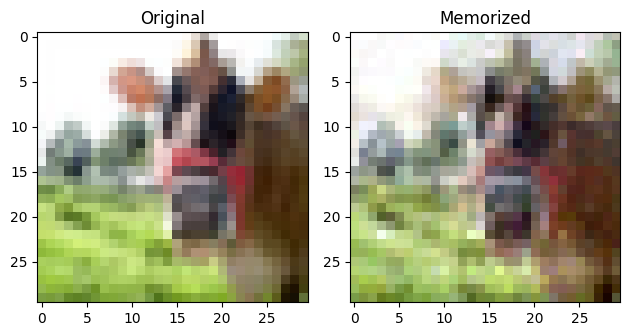

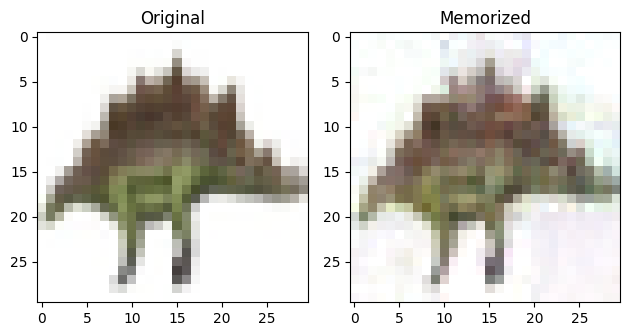

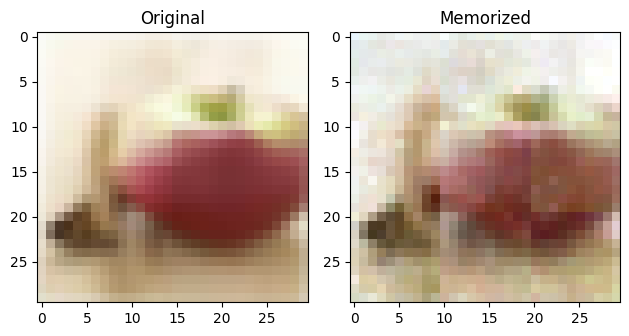

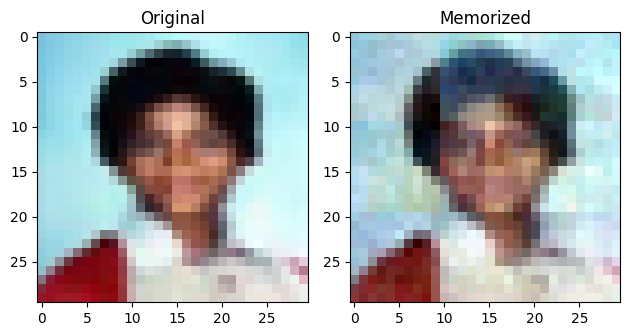

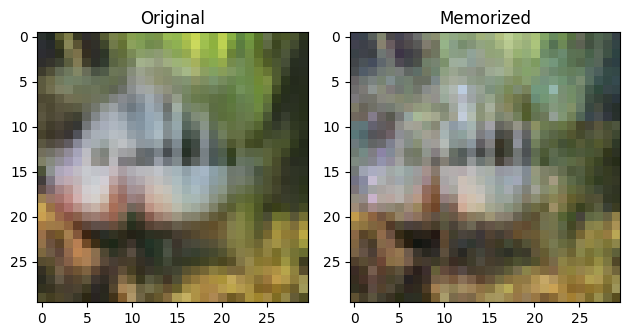

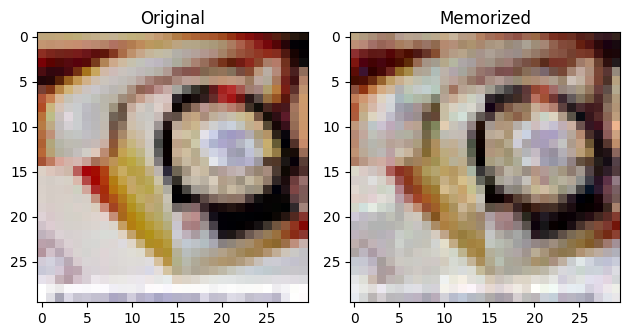

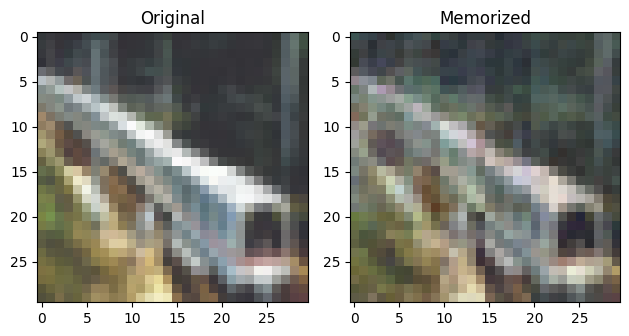

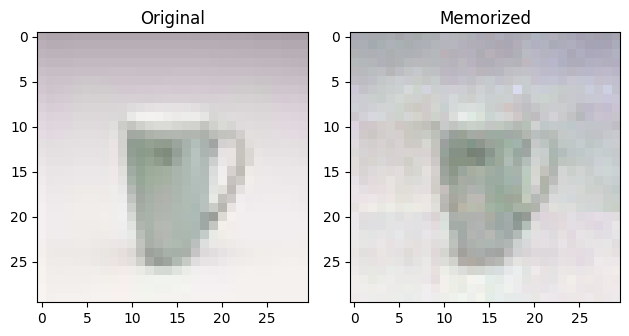

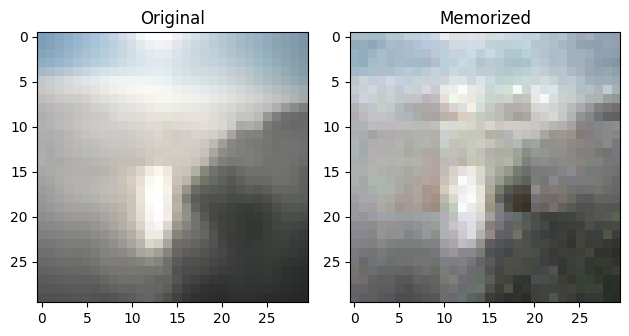

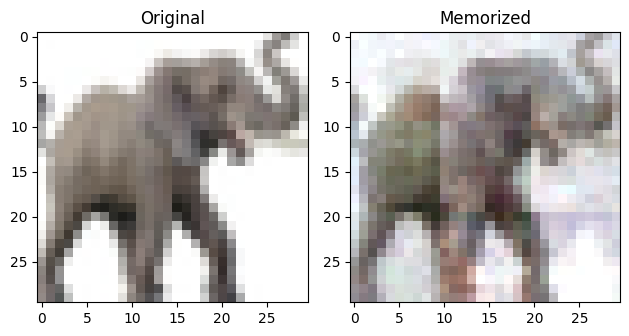

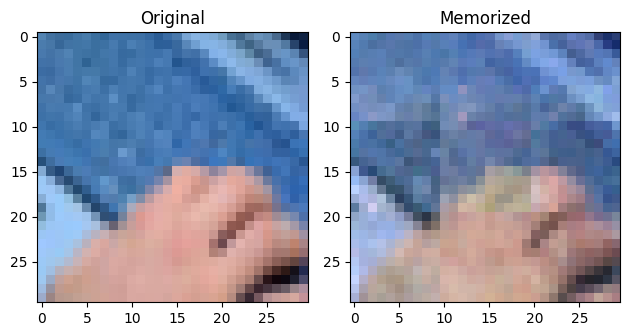

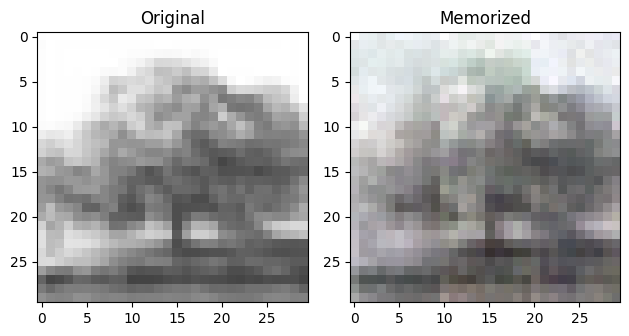

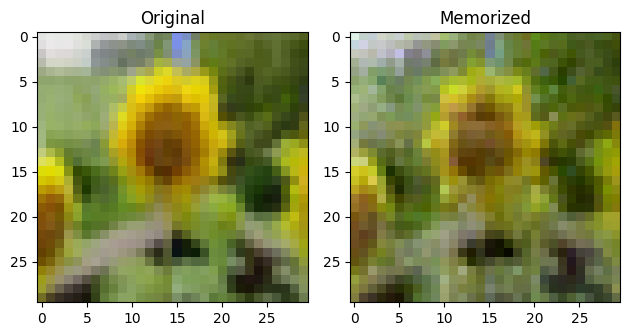

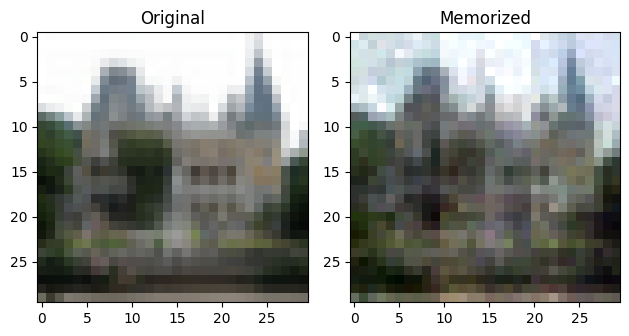

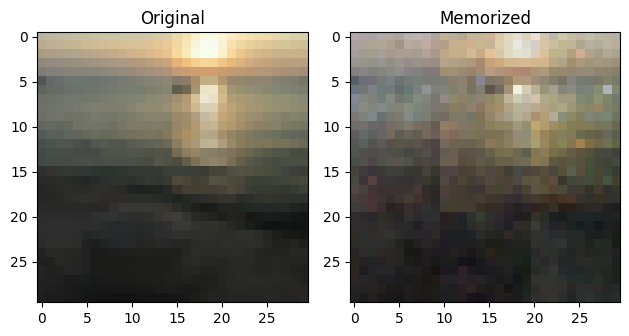

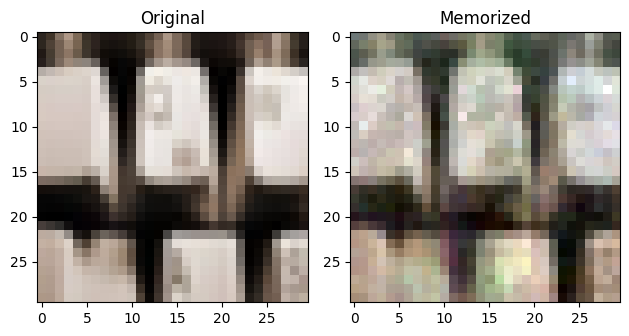

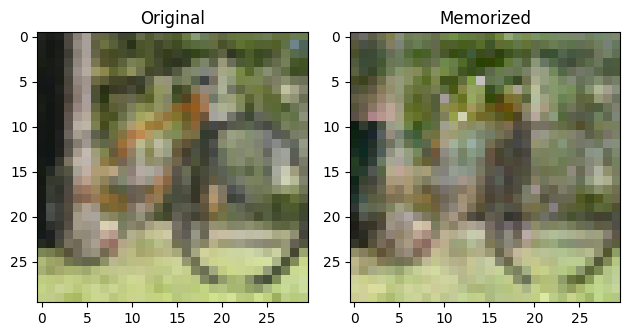

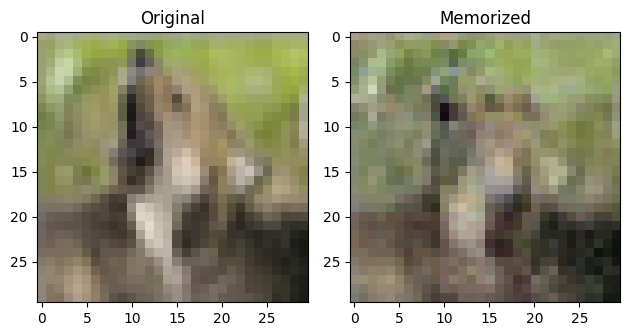

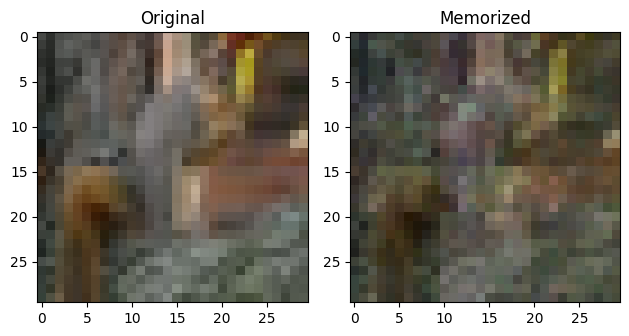

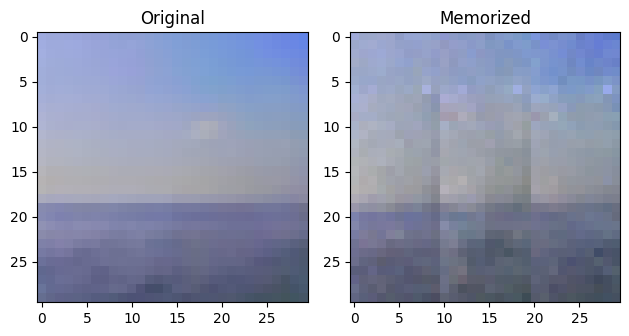

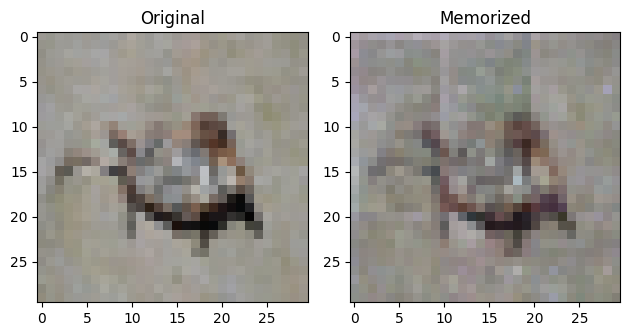

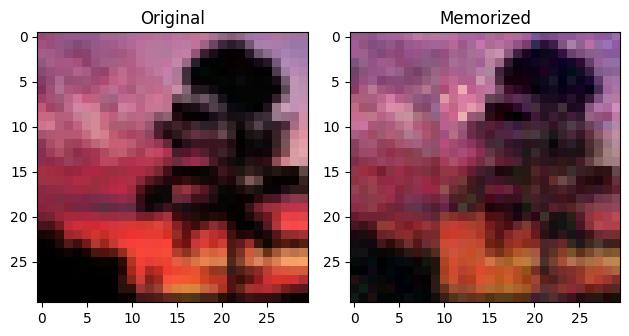

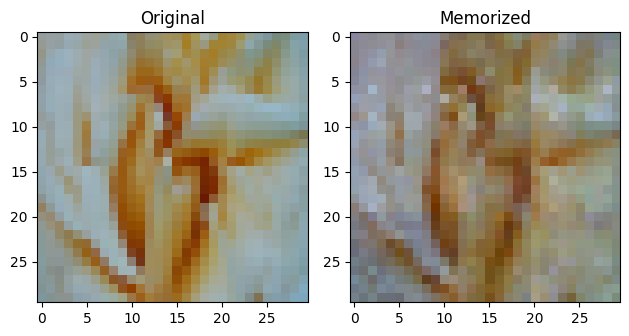

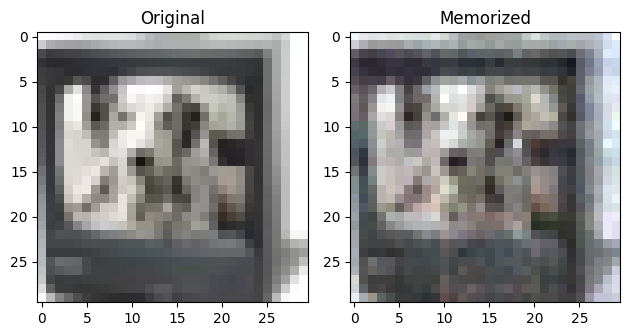

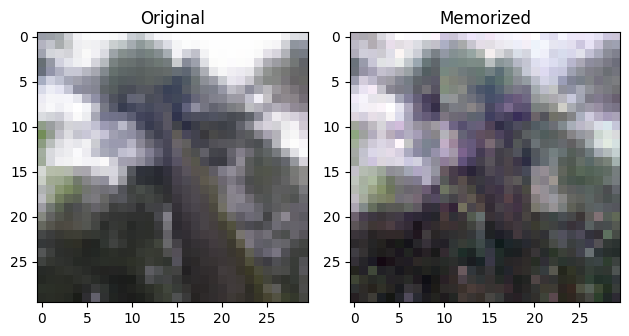

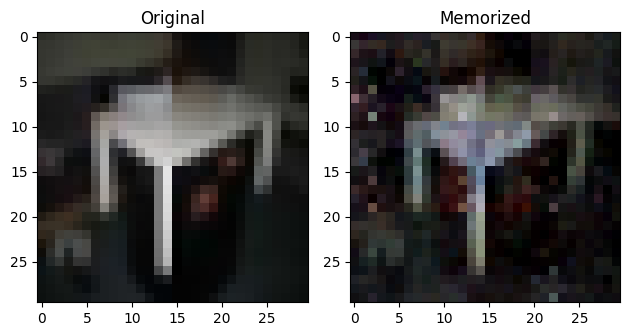

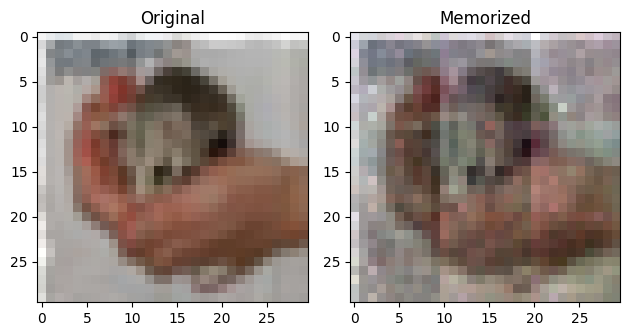

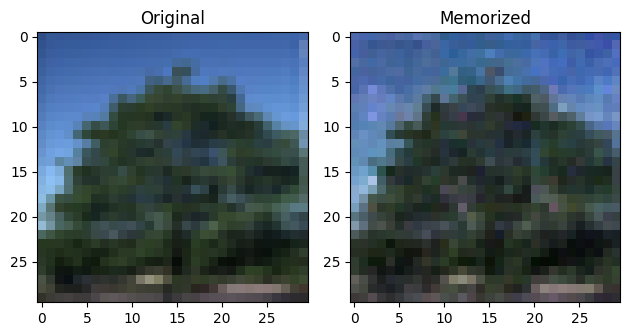

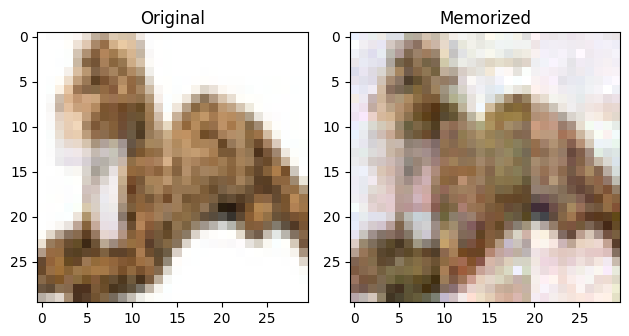

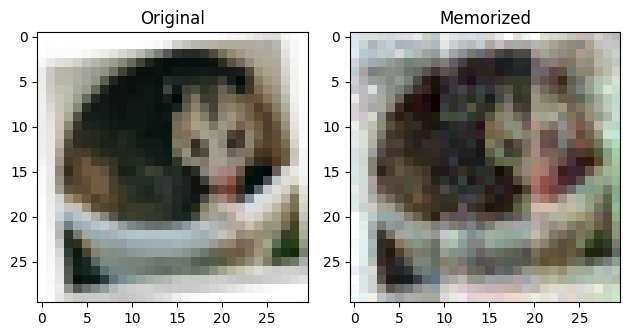

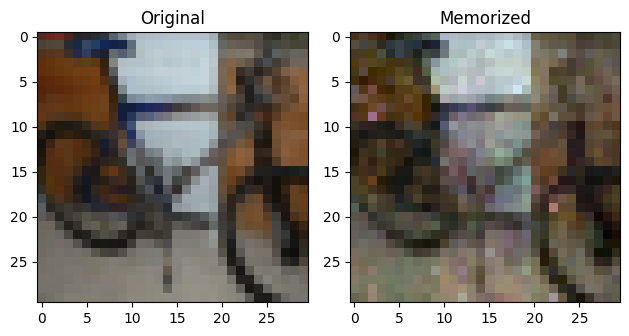

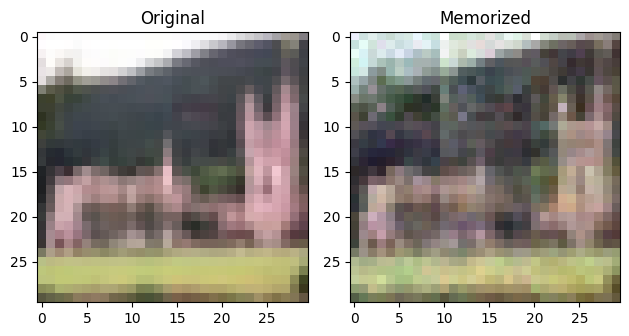

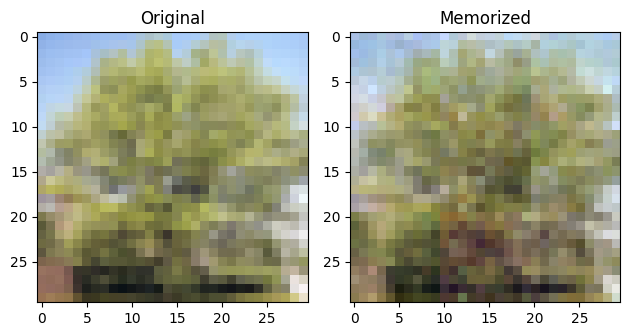

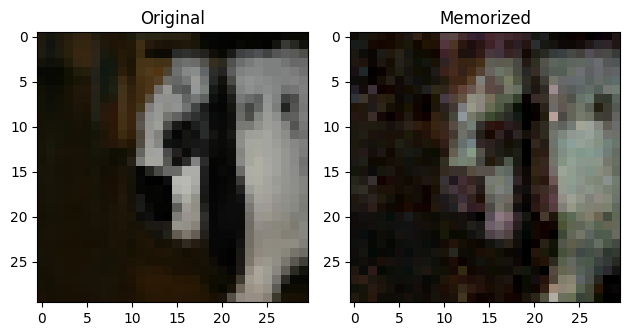

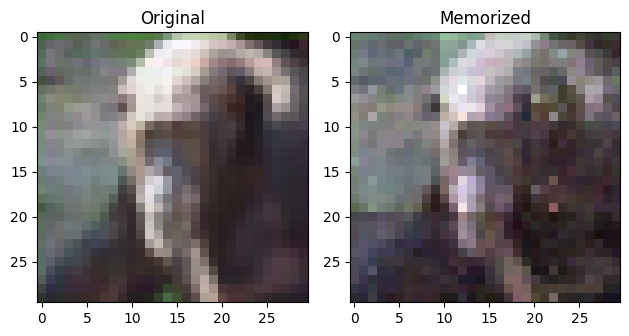

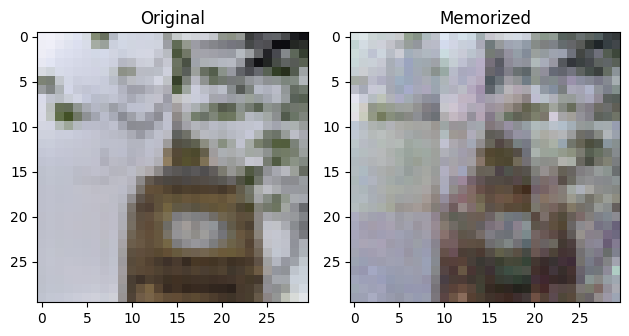

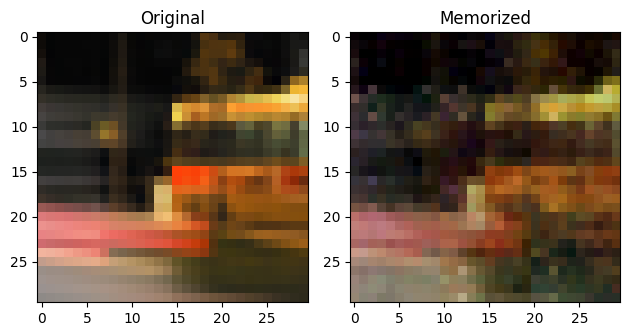

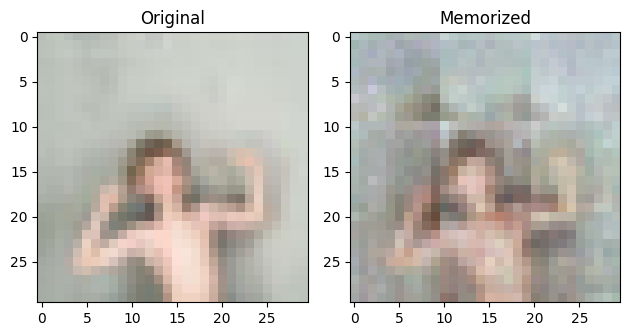

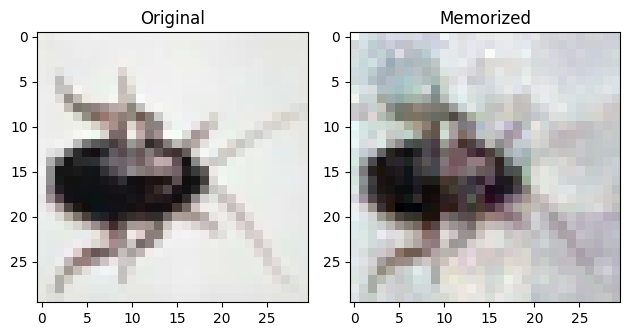

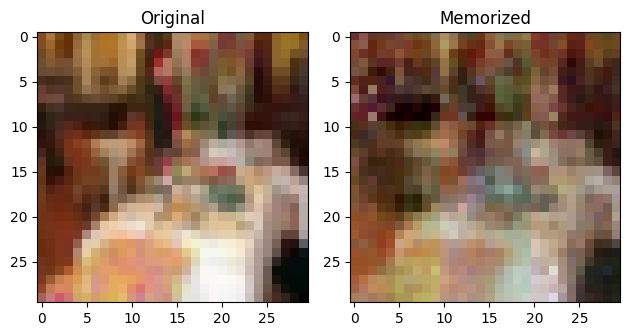

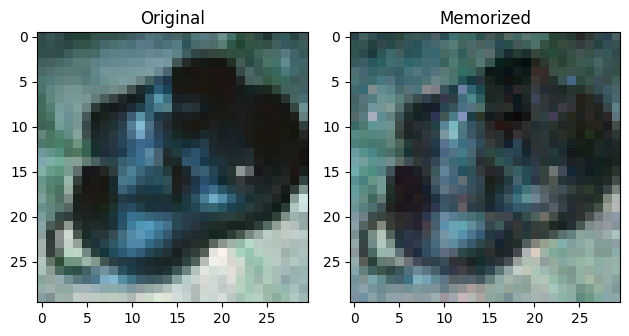

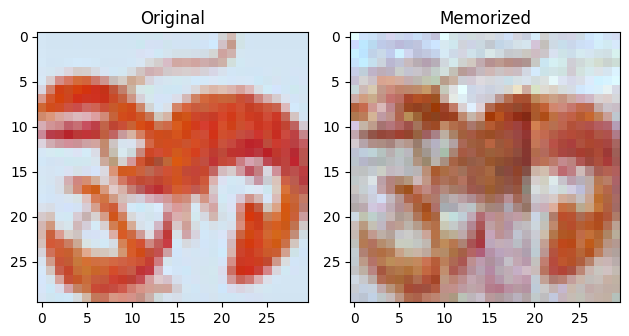

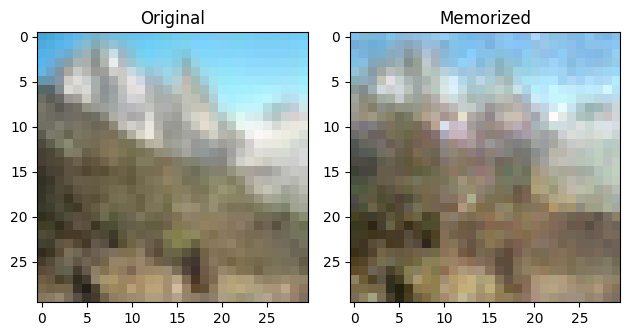

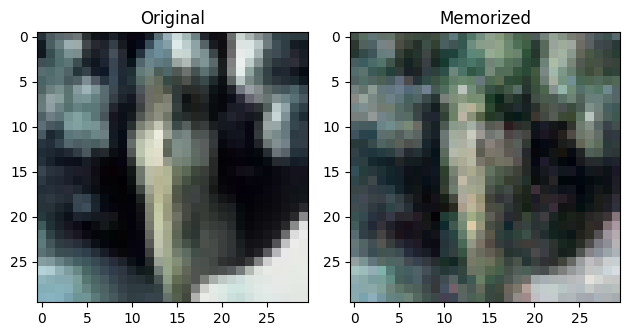

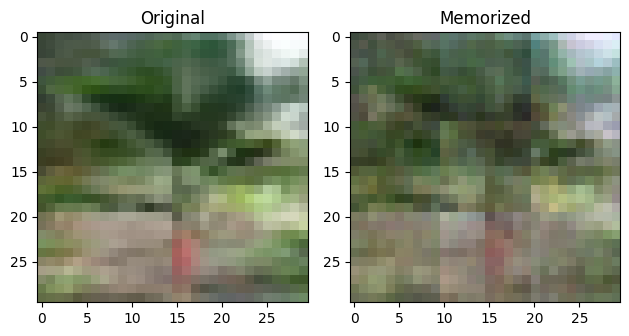

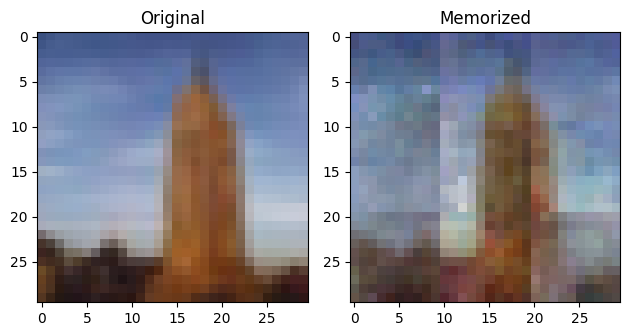

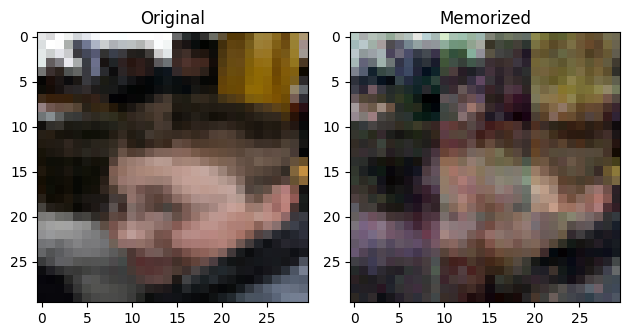

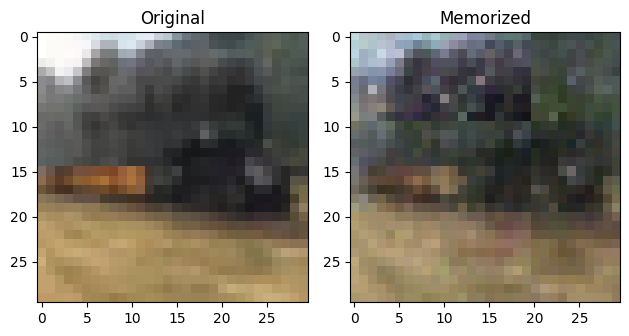

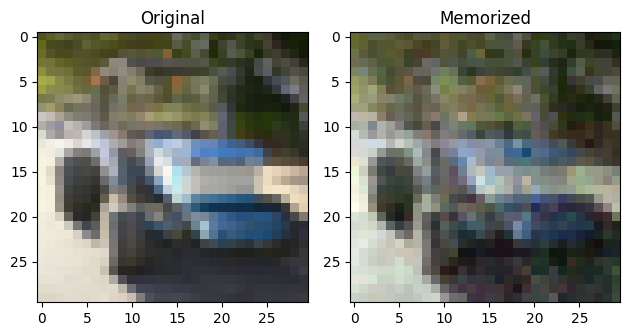

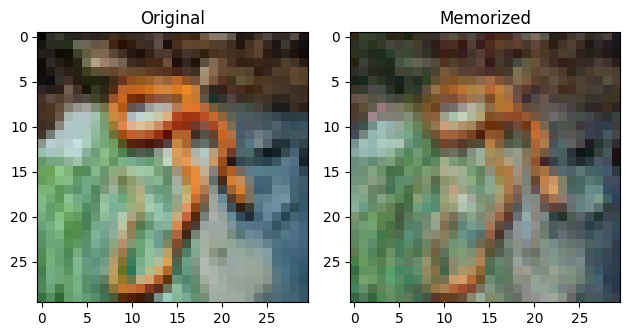

In [ ]:
# model = best_model
for idx in range(50):
    output, target_image = get_image(idx, model)
    target_image = target_image / 255.0
    target_image_perm = target_image.permute(1, 2, 0).cpu().numpy()
    output_perm = torch.clamp(output, 0, 1).permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(ncols=2, tight_layout=True)
    ax[0].imshow(target_image_perm)
    ax[0].set_title('Original')
    ax[1].imshow(output_perm)
    ax[1].set_title('Memorized')
    plt.show()

In [ ]:
def generate_reconstructed_images_and_labels(model, device, mem_dataset):
    num_samples = int(SAMPLE_PERCENTAGE * TRAIN_DATASET_LEN)

    reconstructed_images = []
    original_images = []
    labels = []

    for idx in range(num_samples):
        output, target_image = get_image(idx, model)
        reconstructed_images.append(output.to(device))
        original_images.append(target_image.to(device))

        one_hot_label_region = mem_dataset.gray_codes[idx][1][:-3, :]
        label = one_hot_label_region.argmax().item()
        labels.append(label)

    reconstructed_images = torch.stack(reconstructed_images)
    original_images = torch.stack(original_images)

    # Normalize the original images to [0, 1]
    original_images = original_images.float() / 255.0
    # Clamp the reconstructed images to [0, 1] to remove any negative values
    reconstructed_images = torch.clamp(reconstructed_images, 0, 1)
    labels = torch.tensor(labels, device=device)

    return reconstructed_images, original_images, labels

SSIM

In [ ]:
# ssim token from GitHub - https://github.com/Po-Hsun-Su/pytorch-ssim/blob/master/pytorch_ssim/__init__.py
import torch
import torch.nn.functional as F

WINDOW_SIZE = 3

def gaussian(window_size, sigma):
    gauss = torch.tensor([-(x - window_size // 2) ** 2 / float(2 * sigma ** 2) for x in range(window_size)])
    gauss = torch.exp(gauss)
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def _ssim(img1, img2, window, window_size, channel, size_average=True):
    mu1 = F.conv2d(img1, window, padding=window_size // 2, groups=channel)
    mu2 = F.conv2d(img2, window, padding=window_size // 2, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size // 2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size // 2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size // 2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size=WINDOW_SIZE, size_average=True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    window = window.to(img1.device)
    return _ssim(img1, img2, window, window_size, channel, size_average)

# add this function

def calculate_ssim_for_batches(reconstructed_images, original_images, window_size=WINDOW_SIZE):
    if reconstructed_images.dim() == 3:  # Add channel dimension if not present
        reconstructed_images = reconstructed_images.unsqueeze(1)
    if original_images.dim() == 3:  # Add channel dimension if not present
        original_images = original_images.unsqueeze(1)

    device = original_images.device
    channel = original_images.size(1)
    window = create_window(window_size, channel).to(device)
    window = window.to(device)

    # Calculate SSIM for each image in the batch
    ssim_scores = _ssim(reconstructed_images, original_images, window, window_size, channel, size_average=False)
    return ssim_scores, ssim_scores.mean().item()


In [ ]:
# Generate reconstructed images and original images
reconstructed_images, original_images, labels = generate_reconstructed_images_and_labels(best_model, device, mem_dataset)

# Calculate SSIM values for the batches
ssim_values, average_ssim = calculate_ssim_for_batches(reconstructed_images, original_images)

# Print SSIM values and the average SSIM
print(f'SSIM values: {ssim_values}')
print(ssim_values.shape)
print(f'Average SSIM: {average_ssim}')

SSIM values: tensor([0.8474, 0.8562, 0.8422, 0.7758, 0.7923, 0.8587, 0.8376, 0.8502, 0.7514,
        0.7680, 0.7813, 0.8084, 0.7459, 0.7877, 0.7845, 0.7449, 0.8209, 0.8052,
        0.7614, 0.8118, 0.7721, 0.7258, 0.7728, 0.8831, 0.8007, 0.6268, 0.7539,
        0.8028, 0.7585, 0.7831, 0.7437, 0.7488, 0.7852, 0.6411, 0.7159, 0.7459,
        0.6873, 0.7319, 0.7390, 0.6591, 0.7709, 0.7058, 0.7784, 0.7107, 0.7855,
        0.6838, 0.6445, 0.7464, 0.7709, 0.8198], device='cuda:0')
torch.Size([50])
Average SSIM: 0.766528308391571
